# My SSGA

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

### Import dataset

145 145 200


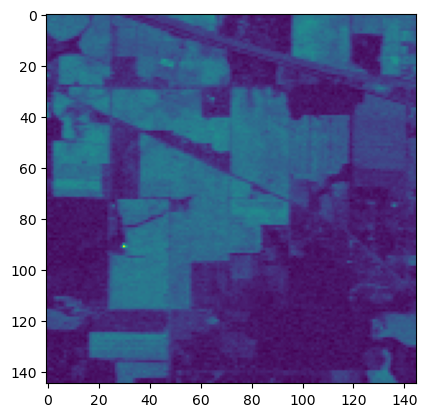

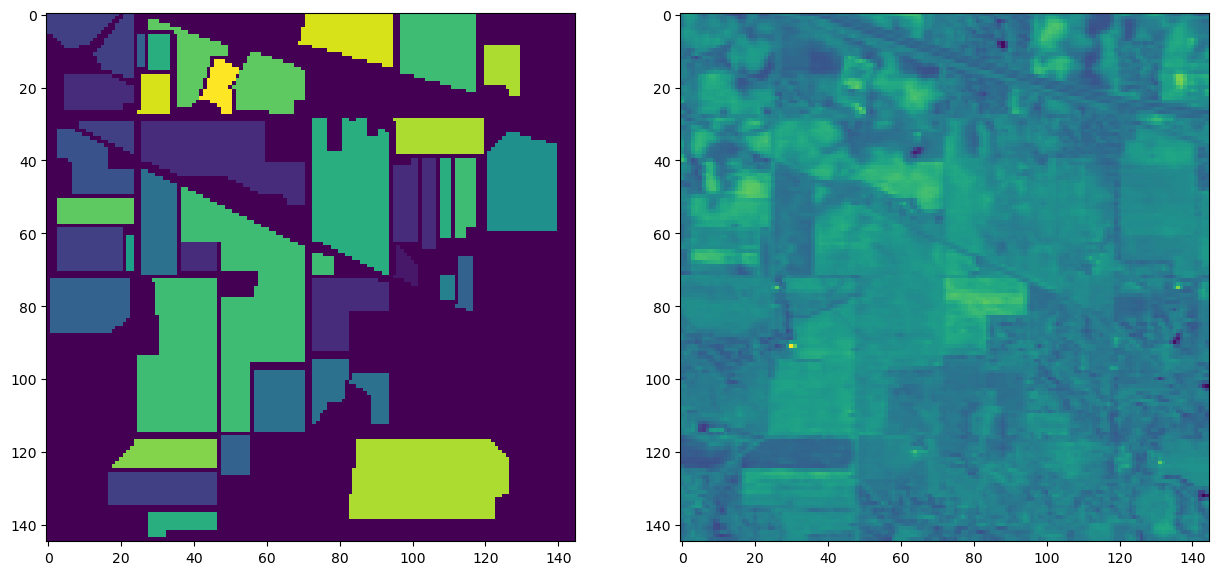

In [2]:

usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
print(N,M,B)
trainData = Data.standardize_data(usedDataset["data"])


b = np.random.randint(0, B-1)
plt.imshow(usedDataset["data"][:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

In [ ]:
from sklearn.decomposition import PCA

class SPInfo:
    def __init__(self, pixels, data, n_component):
        self.time_series = np.array([data[x,y] for x,y in pixels])
        self.mean = np.average(self.time_series, axis=0)
        self.std = np.std(self.time_series, axis=0)
        self.neighboor = set()

        self.n_component = min(n_component, min(self.time_series.shape))

        self.pca = PCA(n_components=self.n_component)
        self.coeffs = self.pca.fit_transform(self.time_series)
        self.components = np.array([self.pca.components_[i]+self.pca.mean_ for i in range(self.n_component)])     

In [123]:
def CosineSim(x,y):
    return 1-(np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)) +1)/2


def PerasonCorrelation(x,y):
    sx = (x-np.average(x))/np.std(x)
    sy = (x-np.average(y))/np.std(y)
    return CosineSim(sx,sy)


def sim_comp_perason(comp1, comp2):
    n,_ = comp1.shape
    m,_ = comp2.shape
    distances = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            distances[i,j] = PerasonCorrelation(comp1[i], comp2[j])
    return np.average(distances)


def comp_SP(info1:SPInfo, info2:SPInfo):
    compSim = sim_comp_perason(info1.components, info2.components)
    return compSim


def compute_medoid(group, simFun=PerasonCorrelation):
    n,_ = group.shape
    distances = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if i!=j:
                distances[i] += simFun(group[i], group[j])
    metroid_index = np.argmin(distances)
    return group[metroid_index]

### Compute SPs

##### Choice of K

Want $K$ respecting two criteria:

First criteria:
$$\frac{N M}{K} \geq P_{avg} \Leftrightarrow K\leq \frac{NM}{P_{avg}}$$
with $P_{avg}$ a constant (=20).

Second Criteria:
$$P_s \geq \delta \Leftrightarrow f(\frac{NM}{K}) \geq \frac{\delta}{\gamma} \Leftrightarrow K \leq \frac{NM}{f^{-1}(\frac{\delta}{\gamma})}$$
with $\delta$ the number of component used in PCA, $f : x \mapsto x ln^2(x)$.

Therefore, the criteria on $K$ can be merge to get:
$$ K\leq \frac{NM}{max(P_{avg},\; f^{-1}(\frac{\delta}{\gamma}))}$$

In [ ]:
from scipy.optimize import root_scalar

def merge_SP(SPs_or, SPs_info_or, K, data, simFun=comp_SP):
    def insert_sorted(l, elt):
        _,_,w = elt
        left, right = 0, len(l)
        while left < right:
            mid = (left+right)//2
            if l[mid][2]<w:
                left = mid+1
            else:
                right = mid
        l.insert(left, elt)


    n_component = SPs_info_or[0].n_component
    SPs = [SP.copy() for SP in SPs_or]
    SPs_info = [SPInfo(SP, data, n_component) for SP in SPs]
    for i in range(len(SPs)):
        SPs_info[i].neighboor = SPs_info_or[i].neighboor.copy()

    nb_cc = len(SPs)
    existing = [True for _ in range(nb_cc)]
    edges = [(u, v, simFun(SPs_info[u], SPs_info[v])) for u in range(nb_cc)
                for v in SPs_info[u].neighboor if u<v]
    edges.sort(key=lambda x:x[2])
    
    while nb_cc > K and len(edges)>0:
        k1,k2,_ = edges.pop(0)
        if existing[k1] and existing[k2]:
            existing[k2] = False
            SPs[k1] += SPs[k2]
            neighboors = SPs_info[k1].neighboor.union(SPs_info[k2].neighboor)
            SPs_info[k1] = SPInfo(SPs[k1], data, n_component)
            SPs_info[k1].neighboor = neighboors

            edges = [(u,v,w) for u,v,w in edges if u!=k1 and v!=k2 and u!=k2 and v!=k1 and existing[u] and existing[v]]
            for v in SPs_info[k1].neighboor:
                if v!=k1 and v!=k2 and existing[v]:
                    insert_sorted(edges, (k1,v,simFun(SPs_info[k1], SPs_info[v])))
            
            nb_cc -=1

    return [SP for i,SP in enumerate(SPs) if existing[i]], [SP_info for i,SP_info in enumerate(SPs_info) if existing[i]]



def compute_SP_by_merging(K):

    # Computing K_or
    def f(x):
        return x * np.log(np.log(x))

    def f_inverse(y, x0=5.0):
        if y <= 0:
            raise ValueError("f(x) = x log(log(x)) is only defined for x > e")
        
        def equation(x):
            return f(x) - y
        
        result = root_scalar(equation, bracket=[np.e + 1e-5, 1e10], method='brentq')
        return result.root

    P_avg = 20
    gamma = 0.15
    n_component = 10
    choosen_max = max(P_avg, f_inverse(n_component/gamma))
    print(choosen_max)
    K_or = int(N*M/choosen_max)
    print(K_or)


    # Computing K_or SP using ERS
    SPs = ERS.find_superpixel(trainData, K_or, lambda_coef="auto", simFun="norm1")
    pixelToSP = np.zeros((N,M), dtype=int)
    for k,SP in enumerate(SPs):
        for x,y in SP:
            pixelToSP[x,y] = k
        
    plt.imshow(usedDataset["gt"])
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
    plt.show()  

    # Compute info
    n_component = 10
    SPs_info = [SPInfo(SP, trainData, n_component) for SP in SPs]
    borders = ERS.find_borders(SPs, (N,M), exterior=True)
    for k1 in range(len(borders)):
        for x,y in borders[k1]:
            k2 = pixelToSP[x,y]
            SPs_info[k1].neighboor.add(k2)

    return merge_SP(SPs, SPs_info, K, trainData)


K = 100
new_SPs, new_SPs_info = compute_SP_by_merging(K)

49.05055563858078
428


In [3]:
K = 100
SPs_or = ERS.find_superpixel(trainData, K,
                          lambda_coef="auto",
                          simFun="norm1",
                          diagonnalyConnected=True)

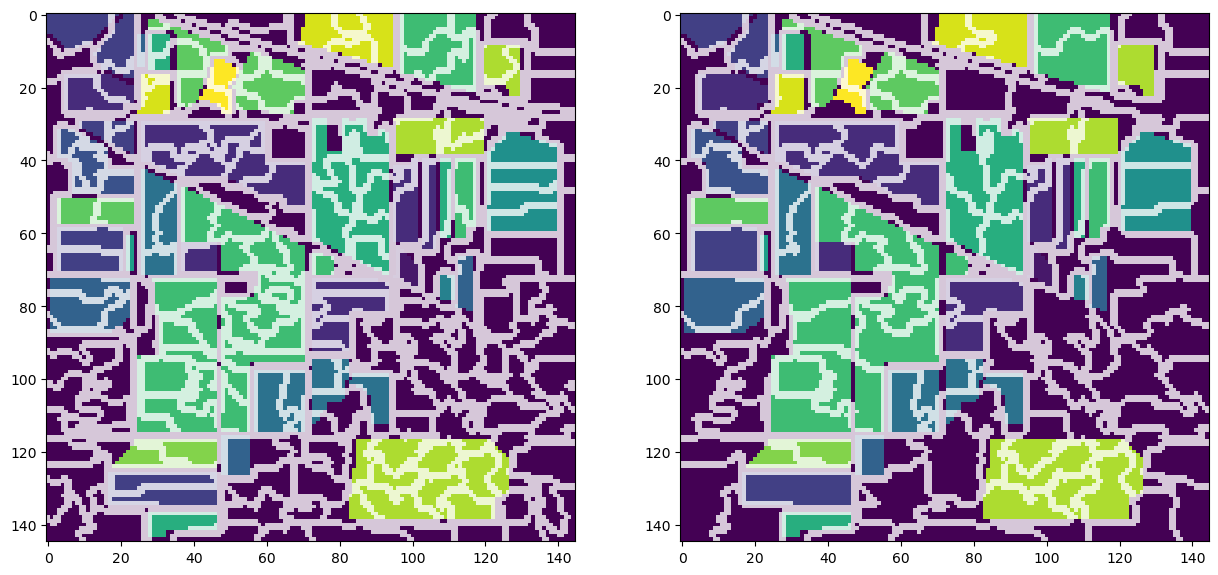

In [4]:

sizeMatter = 200
SPs_or2_or = ERS.find_superpixel(trainData, sizeMatter, lambda_coef=ERS.getLambdaNorm1(K,N,M),
                                 simFun="norm1", shutSizeMatter=200)
SPs_or2 = ERS.find_superpixel(trainData, K,
                          lambda_coef="auto",
                          simFun="norm1",
                          diagonnalyConnected=True,
                          shutSizeMatter=sizeMatter,
                          newLambdaValue=ERS.getLambdaNorm1(sizeMatter, N, M))

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_or2_or, color=[255,255,255,200]))
axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_or2, color=[255,255,255,200]))
plt.show()

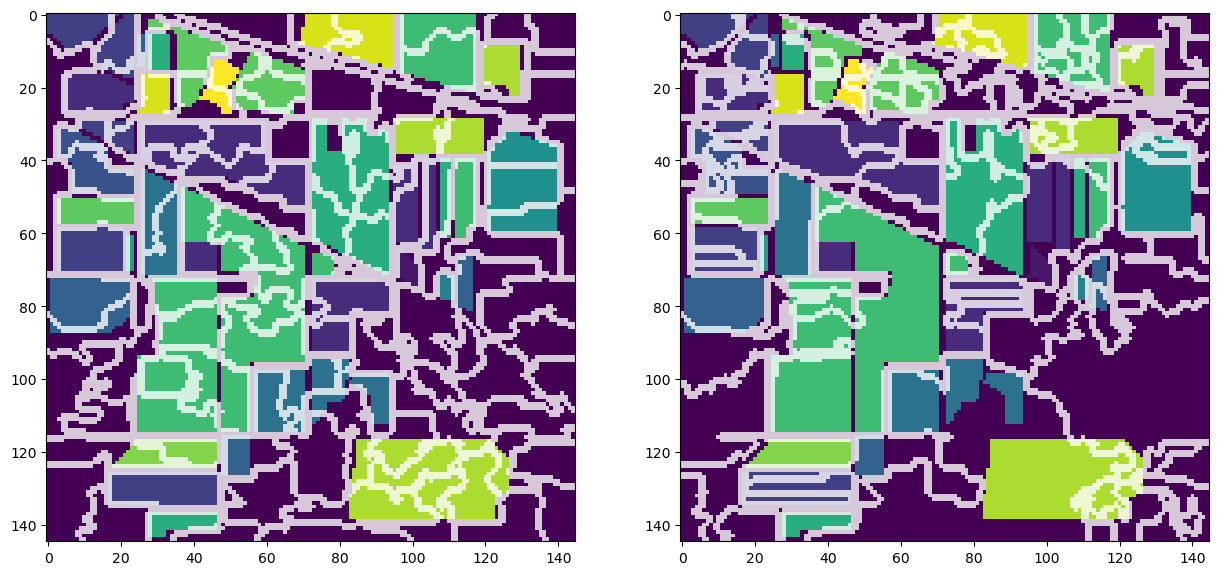

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_or, color=[255,255,255,200]))
axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], new_SPs, color=[255,255,255,200]))
plt.show()

### Times series analysis

In [137]:
K = 50
SPs = ERS.find_superpixel(trainData, K,
                          lambda_coef= int(LC.getLambdaNorm1(K,N,M)),
                          simFun="norm1",
                          diagonnalyConnected=True)
Classifiers = {b:ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b) for b in [True, False]}

In [6]:
SPs = [pixels for key,(name, pixels) in usedDataset["class"].items()]
K = len(SPs)

In [7]:
class Graph:
    def __init__(self, n):
        self.n = n
        self.edges = [set() for _ in range(n)]

    def add_edge(self, u, v):
        self.edges[u].add(v)
        self.edges[v].add(u)

    def composante_connexe(self):
        cc = [-1 for _ in range(self.n)]

        def parcour(cc_id, todo:list):
            while len(todo)!=0:
                u = todo.pop(0)
                if cc[u]==-1:
                    cc[u] = cc_id
                    todo = todo + list(self.edges[u])
                else:   
                    todo = todo

        cc_id = -1
        for i in range(self.n):
            if cc[i]==-1:
                cc_id += 1
                parcour(cc_id, [i])
        return cc


graph = Graph(N*M)
maxi = max(N,M)
for i in range(N):
    for j in range(M):
        u = i*maxi + j

        if i+1<N and usedDataset["gt"][i,j]==usedDataset["gt"][i+1,j]:
            graph.add_edge(u, (i+1)*maxi + j)
        if j+1<M and usedDataset["gt"][i,j]==usedDataset["gt"][i,j+1]:
            graph.add_edge(u, i*maxi + j+1)

cc = graph.composante_connexe()
K = max(cc)+1
SPs = [[] for _ in range(K)]
img = np.zeros((N,M), dtype=int)

for i in range(N):
    for j in range(M):
        u = i*maxi + j
        img[i,j] = cc[u]
        SPs[cc[u]].append((i,j))


#plt.imshow(img)

K = len(SPs)

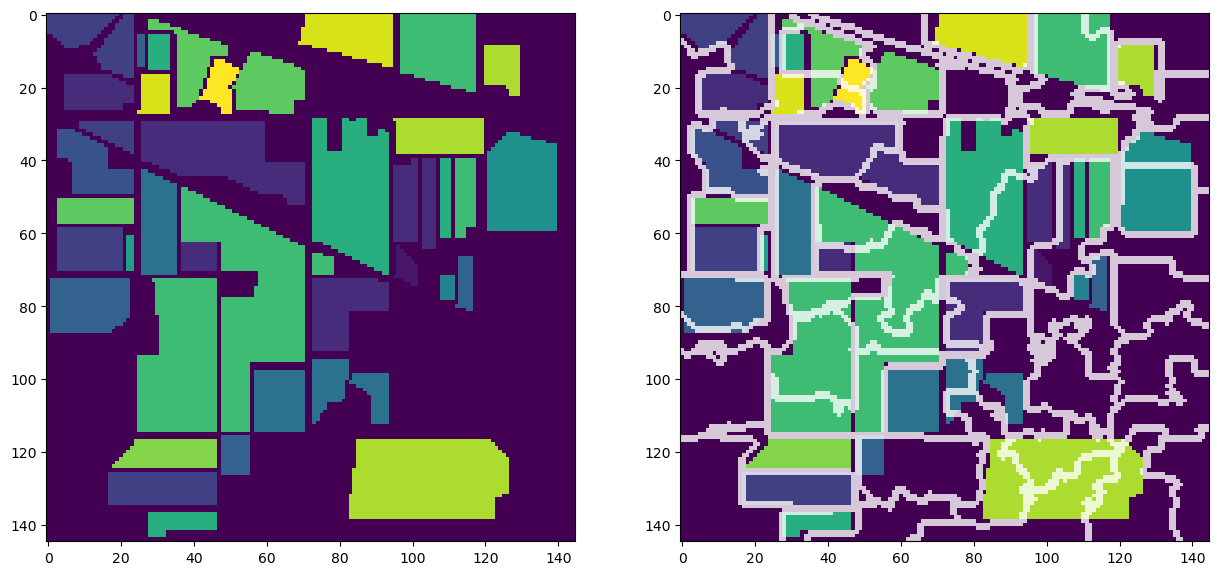

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
plt.show()

In [138]:
b = True
classifier:ERS.SuperpixelClassifier = ERS.SuperpixelClassifier(
        SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
new_SPs = [SP.pixels for SP in classifier.SPs]
K = len(SPs)

In [139]:
n_component = 4
SPs_info = [SPInfo(SP, trainData, n_component) for SP in new_SPs]

### Time series processing

In [140]:
Bs = np.arange(0, B)

def z_normalize(ts):
    ts = np.array(ts)
    return (ts - np.mean(ts)) / np.std(ts)

TS = []
TS_Z = []
for SP in new_SPs:
    TS.append(np.array([trainData[x,y] for x,y in SP]))
    TS_Z.append(np.array([z_normalize(trainData[x,y]) for x,y in SP]))


In [152]:
k1 = np.random.randint(0, K-1)
print(k1)
print(len(SPs[k1]))

23
349


In [148]:
k2 = np.random.randint(0, K-1)
print(k2)
print(len(SPs[k2]))

24
571


In [151]:
k3 = np.random.randint(0, K-1)
print(k3)
print(len(SPs[k3]))

28
474


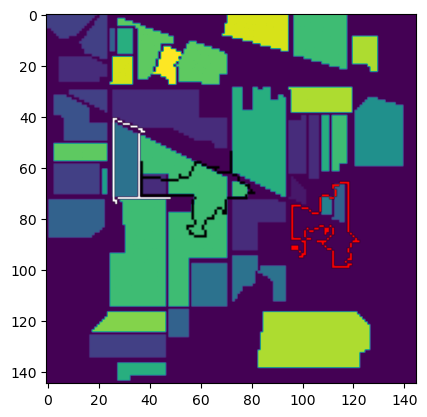

In [153]:
"""
K=50, IndainPines, don'tCount0
k1 = 6
k2 = 13
k3 = 25

K=100 on IndianPines
k1 = 49
k2 = 63
k3 = 42

K=300 on IndianPines
k1 = 132
k2 = 219
k3 = 85

One SP per label:
k1 = 11
k2 = 10
k3 = 6

One SP per connected label:
k1 = 19
k2 = 27
k3 = 49
"""


plt.imshow(usedDataset["gt"])
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [new_SPs[k1]], color=[255,255,255,255]))
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [new_SPs[k2]], color=[0,0,0,255]))
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [new_SPs[k3]], color=[255,0,0,255]))
plt.show()

0.3976160964195124
35.360873336706426


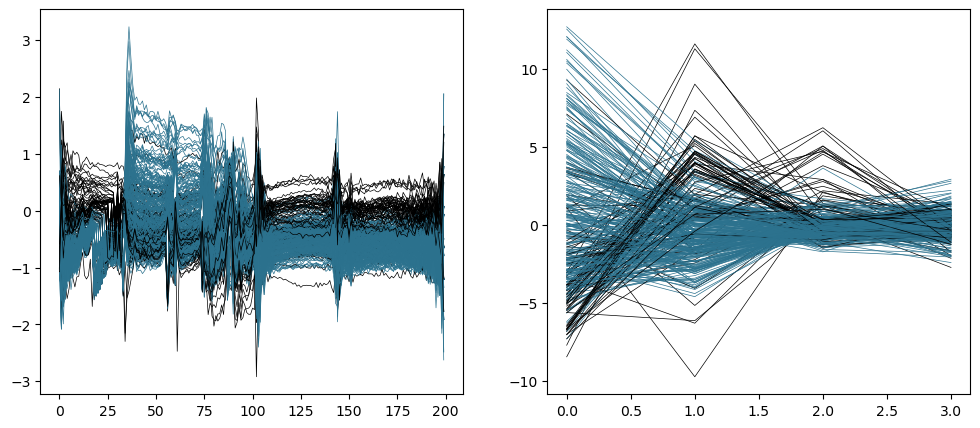

0.32410065029448915
25.386491819416594


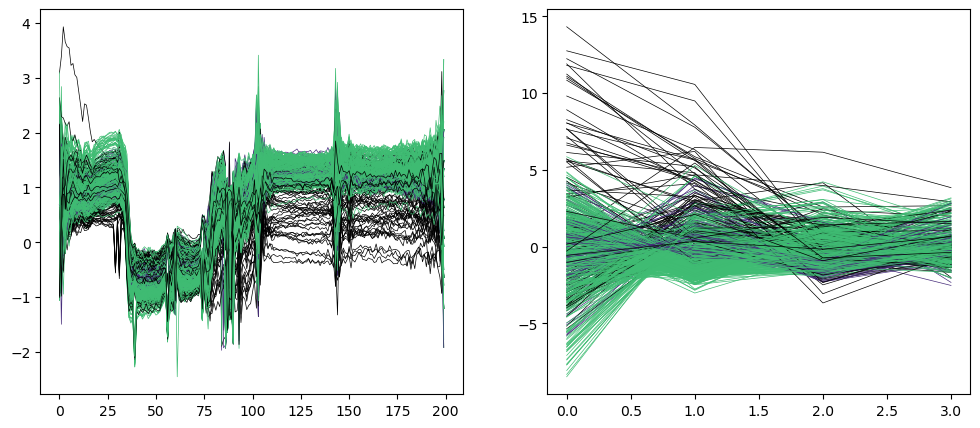

0.5359952774604931
60.853783692472945


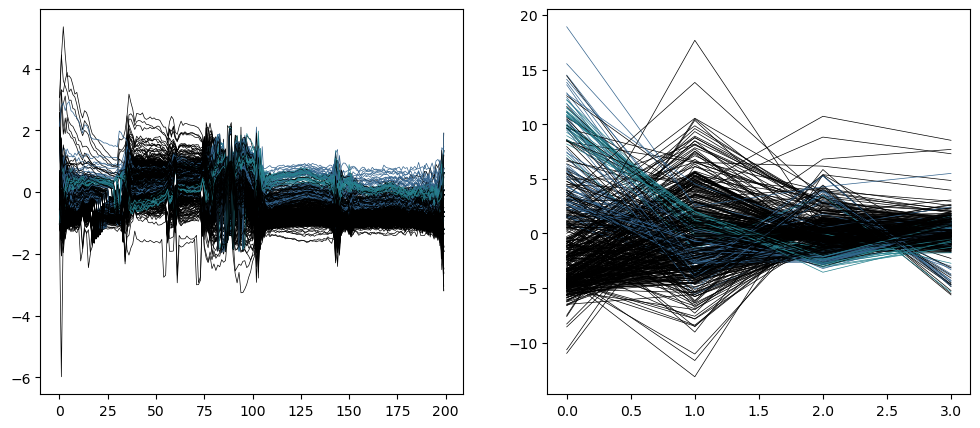

In [155]:
plot_in_space = True
cmap = mpl.colormaps["viridis"]
colors = cmap(np.linspace(0, 1, len(usedDataset["class"])))

for k in [k1, k2, k3]:
    info = SPs_info[k]
    SP = SPs[k]

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    if plot_in_space and n_component==3:
        ax3d = fig.add_subplot(1,2,2, projection='3d')

    for i, (x,y) in enumerate(SP):
        color="black" if usedDataset["gt"][x,y]==0 else colors[usedDataset["gt"][x,y]]
        axs[0].plot(np.arange(0, B), info.time_series[i], "-", color=color, linewidth=0.5)
        if n_component==2:
            axs[1].plot(info.coeffs[i][0], info.coeffs[i][1], "o", color=color)
        elif n_component==3:
            ax3d.plot(info.coeffs[i][0], info.coeffs[i][1], info.coeffs[i][2], "o", color=color)
        else:
            axs[1].plot(np.arange(0, n_component), info.coeffs[i], "-", color=color, linewidth=0.5)


    print(np.mean(np.std(info.time_series, axis=0)))
    print(np.var(info.time_series, axis=0).sum())
    #medoid = compute_medoid(info.time_series) # medoid is bad
    #axs[0].plot(np.arange(0, B), medoid, "-", linewidth=0.5, color="red")

    plt.show()
    

In [34]:
def normalize(vec):
    arr = np.array(vec)
    mini = arr.min()
    maxi = arr.max()
    if mini==maxi:
        return arr/len(arr)
    return (arr-mini)/(maxi-mini)


from scipy.signal import correlate
def sbd(x, y):
    x_norm = z_normalize(x)
    y_norm = z_normalize(y)

    ncc = correlate(x_norm, y_norm, mode='full')

    norm_factor = len(x_norm)
    ncc /= norm_factor

    max_ncc = np.max(ncc)
    distance = 1 - max_ncc

    return distance#, ncc



from pyts.approximation import SymbolicAggregateApproximation
def compute_sax(trainData):
    sax = SymbolicAggregateApproximation(n_bins=5, strategy='normal', window_size="10")
    X_sax = sax.fit_transform(trainData.copy())
    return X_sax

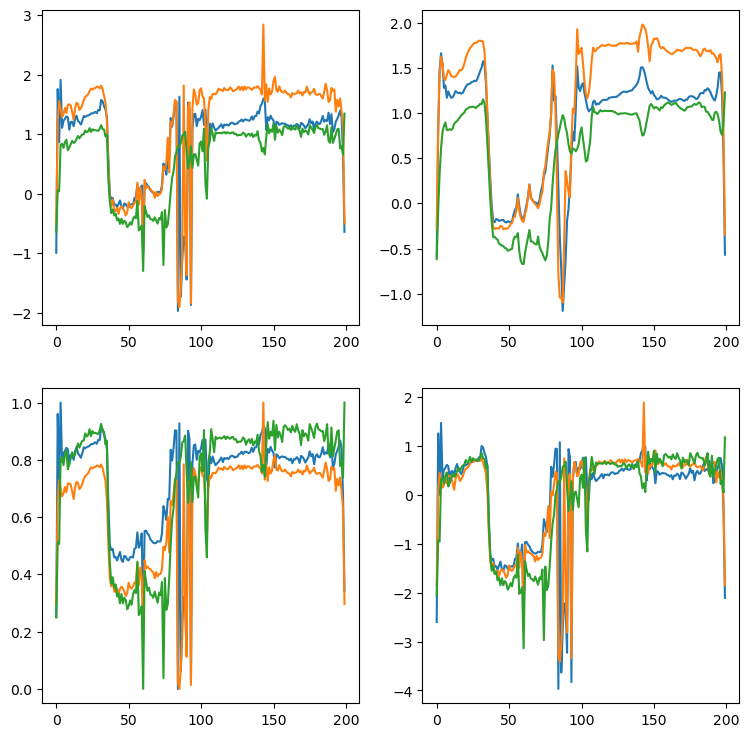

norm1: 0.36766656854432467 0.4175728864179981
cosine: 0.022316354650302905 0.08660147481510827
perason: 0.03656497873645881 0.02536618801699142
sbd: 0.11279970050236143 0.3637214359807325


In [39]:
px = TS[k1][0]
py = TS[k1][2]

pz = TS[k2][0]

from scipy.signal import savgol_filter
fig, axs = plt.subplots(2,2, figsize=(9,9))

for ts in [px,py,pz]:
    p_smooth = savgol_filter(ts, window_length=9, polyorder=3)
    axs[0][0].plot(Bs, ts, "-")
    axs[0][1].plot(Bs, p_smooth)
    axs[1][0].plot(Bs, normalize(ts), "-")
    axs[1][1].plot(Bs, (ts-np.average(ts))/np.std(ts), "-")
plt.show()


print("norm1:", ERS.norm1_similarity(px, py), ERS.norm1_similarity(px, pz))
print("cosine:", CosineSim(px,py), CosineSim(px,pz))
print("perason:", PerasonCorrelation(px,py), PerasonCorrelation(px,pz))
print("sbd:", sbd(px,py), sbd(px,pz))

[0.56719094 0.10333555 0.07252489]


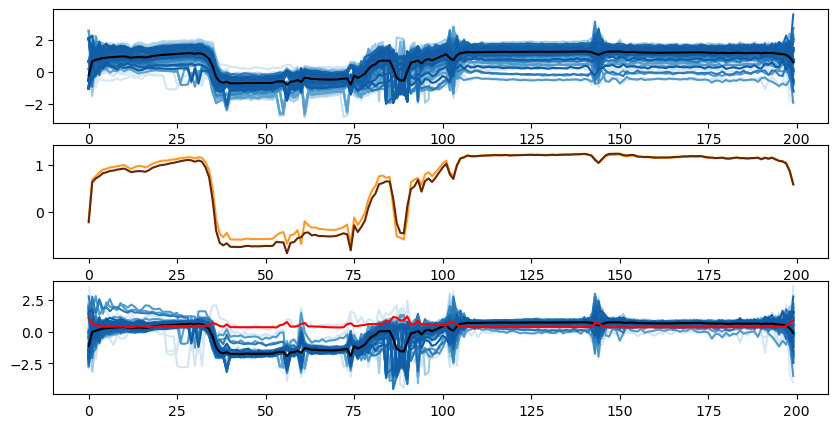

[0.34710558 0.18399603 0.05618801]


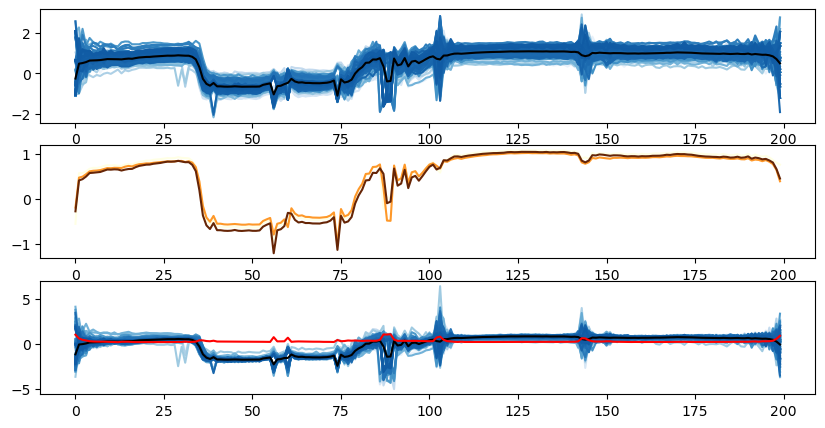

[0.42935225 0.10646114 0.06640007]


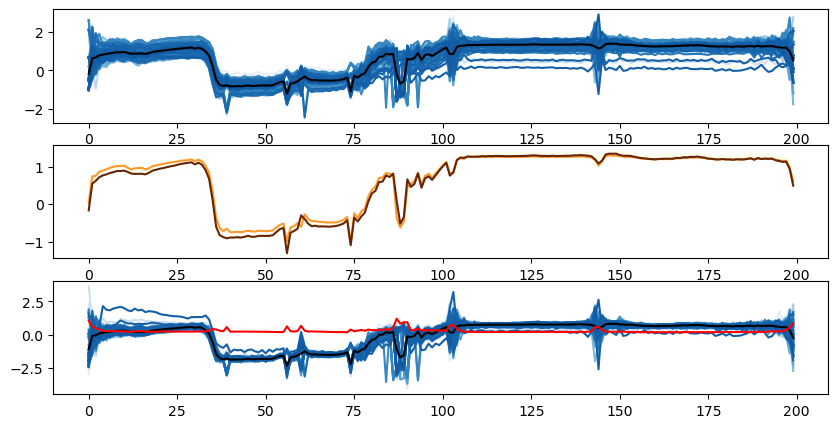

0.19717051560366777
0.08513233763293201
0.23764473241028758

0.012201985196284472
0.0009588242236086378
0.01286018602921842

0.6132008319651618
0.6073946712716563
0.6898604704336067


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


for i, k in enumerate([k1,k2,k3]):
    info:SPInfo = SPs_info[k]

    fig, axs = plt.subplots(3, figsize=(10,5))
    TS_colors = mpl.colormaps["Blues"](np.linspace(0, 1, int(1.2*len(info.time_series))))
    for c,arr in enumerate(info.time_series):
        axs[0].plot(Bs, arr, "-", color=TS_colors[c])

    #medoid = compute_medoid(TS[k])
    #axs[0].plot(Bs, medoid, "-", color="orange", label="medoid")
    axs[0].plot(Bs, info.mean, "-", color="black", label="average")

    #similarites = cosine_similarity(TS[k])
    #print(np.mean(similarites[np.triu_indices_from(similarites, k=1)]))


    print(info.pca.explained_variance_ratio_)
    comp_colors = mpl.colormaps["YlOrBr"](np.linspace(0, 1, n_component))
    for c in range(n_component):
        axs[1].plot(Bs, info.components[n_component-1-c], "-", color=comp_colors[c])

    for c,arr in enumerate(TS_Z[k]):
        axs[2].plot(Bs, arr, "-", color=TS_colors[c])
    axs[2].plot(Bs, np.average(TS_Z[k], axis=0), "-", color="black", label="average")
    #medoid_Z = compute_medoid(TS_Z[k])
    #axs[2].plot(Bs, medoid_Z, "-", color="orange", label="medoid")
    axs[2].plot(Bs, info.std, "-", color="red", label="standard deviation")
    
    plt.show()


def sim_comp_perason(comp1, comp2):
    n,_ = comp1.shape
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            distances[i,j] = PerasonCorrelation(comp1[i], comp2[j])
    return np.average(distances)


from sklearn.cross_decomposition import CCA
def sim_comp_cca(comp1, comp2):
    X = comp1.copy().T
    Y = comp2.copy().T
    cca = CCA(n_components=comp1.shape[0])
    cca.fit(X,Y)
    c1, c2 = cca.transform(X,Y)
    correlations = [np.corrcoef(c1[:,i], c2[:,i])[0,1] for i in range(comp1.shape[0])]
    return 1-np.mean(correlations)/2


print(np.average(np.abs(SPs_info[k1].components - SPs_info[k2].components)))
print(np.average(np.abs(SPs_info[k1].components - SPs_info[k3].components)))
print(np.average(np.abs(SPs_info[k3].components - SPs_info[k2].components)))
print()
print(sim_comp_perason(SPs_info[k1].components, SPs_info[k2].components))
print(sim_comp_perason(SPs_info[k1].components, SPs_info[k3].components))
print(sim_comp_perason(SPs_info[k3].components, SPs_info[k2].components))
print()
print(sim_comp_cca(SPs_info[k1].components, SPs_info[k2].components))
print(sim_comp_cca(SPs_info[k1].components, SPs_info[k3].components))
print(sim_comp_cca(SPs_info[k3].components, SPs_info[k2].components))

### Merge SPs

In [ ]:
def SP_average(data, SP):
    N,M,B = data.shape
    res = np.zeros(B)
    for x,y in SP:
        res += data[x,y,:]
    return res/len(SP)


def squaredDist(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2

def SP_weighted_average(data, SP):
    c = np.average(SP, axis=0)
    dists = np.array([np.exp(-0.5*squaredDist(a, c)**0.5) for a in SP])
    if dists.max()-dists.min()!=0:
        dists = (dists-dists.min())/(dists.max()-dists.min())
    else:
        dists = [1/len(dists) for _ in range(len(SP))]

    N,M,B = data.shape
    res = np.zeros(B)
    for i,(x,y) in enumerate(SP):
        res += dists[i] * data[x,y,:]
    return res/len(SP)


def norm1(x,y):
    return np.abs(x-y).sum()/len(x)

def norm2(x,y):
    return ((x-y)**2).sum()/len(x)


def merge_SPs_basic(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_average(data, SP)] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1], SPs_liste[j][1]) for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        SPs_liste[k1] = [SP_union, SP_average(data, SP_union)] #Opti to compute average easy without dividing by len(SP)
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]
       


def merge_SPs_v2(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_weighted_average(data, SP)*len(SP)] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1]/len(SPs_liste[i][0]),
                         SPs_liste[j][1]/len(SPs_liste[j][0]))
                    for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        SPs_liste[k1] = [SP_union, SPs_liste[k1][1] + SPs_liste[k2][1]]
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1]/len(SPs_liste[k1][0]),
                                        SPs_liste[k][1]/len(SPs_liste[k][0]))
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1]/len(SPs_liste[k1][0]),
                                        SPs_liste[k][1]/len(SPs_liste[k1][0]))
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]



def merge_SPs_v3(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_average(data, SP), len(SP)] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1], SPs_liste[j][1]) for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        selected = k1 if SPs_liste[k1][2] > SPs_liste[k2][2] else k2
        SPs_liste[k1] = [SP_union, SPs_liste[selected][1], len(SP_union)]
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1], SPs_liste[k][1]) #Opti to compute average easy without dividing by len(SP)
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]
       



        
from sklearn.cluster import KMeans
def merge_SPs_kmeans(data, SPs, L):
    nb_cluster = L
    kmeans = KMeans(n_clusters=nb_cluster, n_init="auto")
    features = [SP_average(data, SP) for SP in SPs]
    kmeans.fit(features)

    SPs_merged = [[] for _ in range(nb_cluster)]
    for i in range(len(kmeans.labels_)):
        SPs_merged[kmeans.labels_[i]] += SPs[i]
    return SPs_merged



from sklearn.cluster import AgglomerativeClustering
def merge_Sps_agglomerative(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = AgglomerativeClustering(n_clusters=L, linkage='ward')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


from sklearn.cluster import SpectralClustering
def merge_Sps_spectral(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = SpectralClustering(n_clusters=L, affinity='nearest_neighbors', assign_labels='kmeans')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


In [43]:
dataForMerges = Data.standardize_data(usedDataset["data"])
SPsUsedForMerges = {b:[SP.pixels for SP in Classifiers[b].SPs] for b in Classifiers.keys()}

L = 17
print("number of labels:", len(usedDataset["labels"]))
print("number of clusters:", L)

sf = norm2
mergedSPsDic = {key:[SPs,
             merge_SPs_basic(dataForMerges, SPs, L, simFun=sf),
             merge_SPs_v2(dataForMerges, SPs, L, simFun=sf),
             merge_SPs_v3(dataForMerges, SPs, L, simFun=sf),
             merge_SPs_kmeans(dataForMerges, SPs, L),
             merge_Sps_agglomerative(dataForMerges, SPs, L),
             merge_Sps_spectral(dataForMerges, SPs, L)]

             for key,SPs in SPsUsedForMerges.items()}

merged_SPs_names = ["without", "v1", "v2", "v3", "kmeans", "agglomerative", "SpectralClustering"]

number of labels: 17
number of clusters: 17


300
[72, 82, 49, 57, 76, 50, 90, 100, 50, 69, 72, 64, 93, 74, 54, 45, 83, 64, 55, 43, 52, 56, 68, 48, 39, 52, 52, 92, 88, 65, 70, 68, 84, 82, 75, 104, 64, 63, 38, 77, 91, 84, 50, 81, 82, 51, 87, 101, 77, 48, 75, 96, 53, 79, 69, 86, 60, 59, 51, 64, 93, 71, 82, 76, 58, 56, 34, 58, 58, 90, 63, 100, 83, 53, 55, 72, 75, 55, 66, 44, 59, 75, 68, 59, 87, 76, 50, 60, 62, 55, 85, 82, 100, 73, 51, 61, 78, 63, 88, 67, 69, 40, 102, 84, 68, 74, 96, 63, 58, 95, 89, 62, 46, 84, 93, 57, 90, 60, 52, 84, 51, 60, 58, 61, 52, 81, 59, 79, 67, 80, 100, 75, 61, 62, 80, 93, 111, 82, 65, 51, 76, 70, 63, 59, 68, 82, 82, 50, 53, 50, 58, 74, 58, 48, 94, 81, 110, 49, 44, 64, 53, 73, 87, 55, 52, 77, 55, 78, 62, 58, 70, 51, 88, 75, 45, 71, 87, 47, 36, 65, 84, 77, 62, 103, 85, 76, 78, 67, 48, 81, 74, 58, 70, 61, 113, 63, 86, 68, 87, 80, 62, 62, 64, 91, 78, 41, 74, 69, 108, 81, 57, 53, 82, 64, 45, 84, 79, 53, 96, 79, 72, 64, 85, 111, 56, 72, 100, 83, 70, 65, 67, 74, 89, 58, 48, 101, 44, 64, 101, 89, 69, 88, 80, 73, 62,

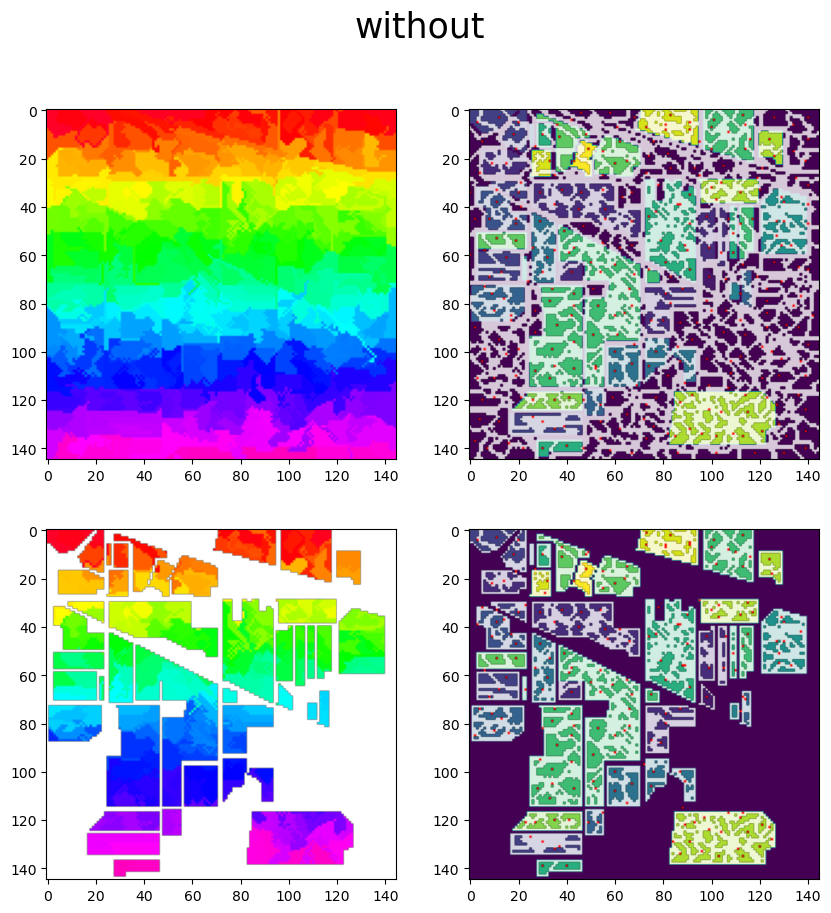

17
[5196, 1584, 274, 1604, 412, 5434, 707, 82, 159, 3449, 1063, 407, 242, 40, 57, 121, 194]
17
[3598, 1409, 354, 383, 163, 133, 344, 783, 1361, 46, 657, 82, 304, 397, 32, 1, 202]


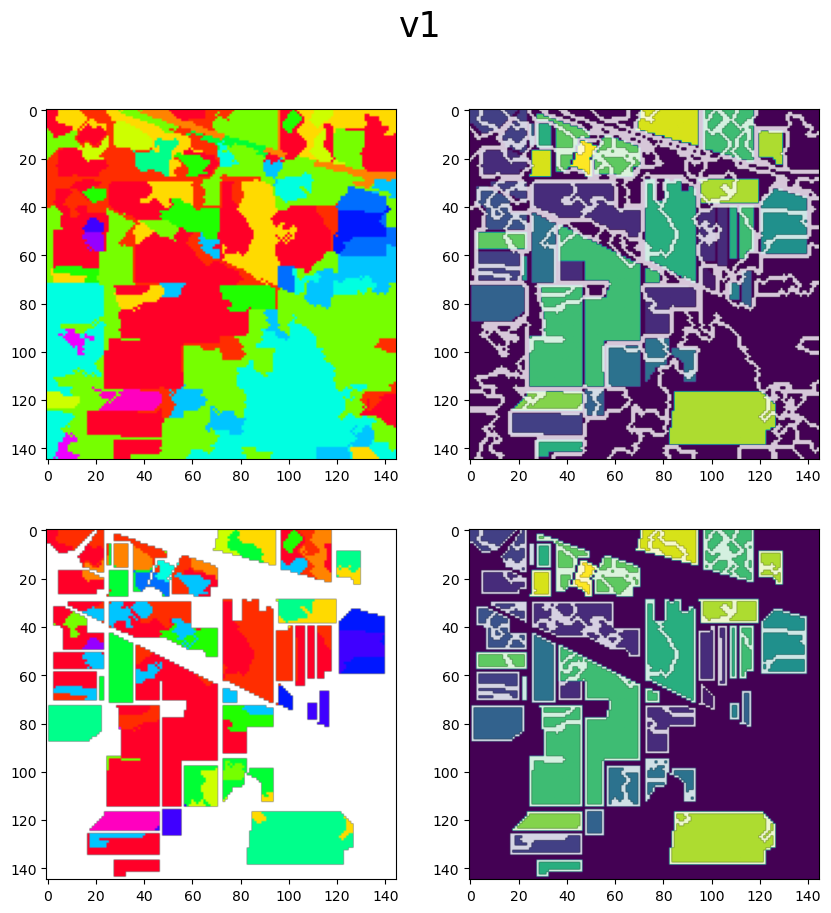

17
[1660, 926, 4359, 2999, 541, 5441, 388, 318, 1107, 159, 1132, 925, 123, 352, 40, 118, 437]
17
[5788, 717, 953, 46, 1904, 18, 46, 1, 231, 168, 32, 194, 12, 1, 1, 120, 17]


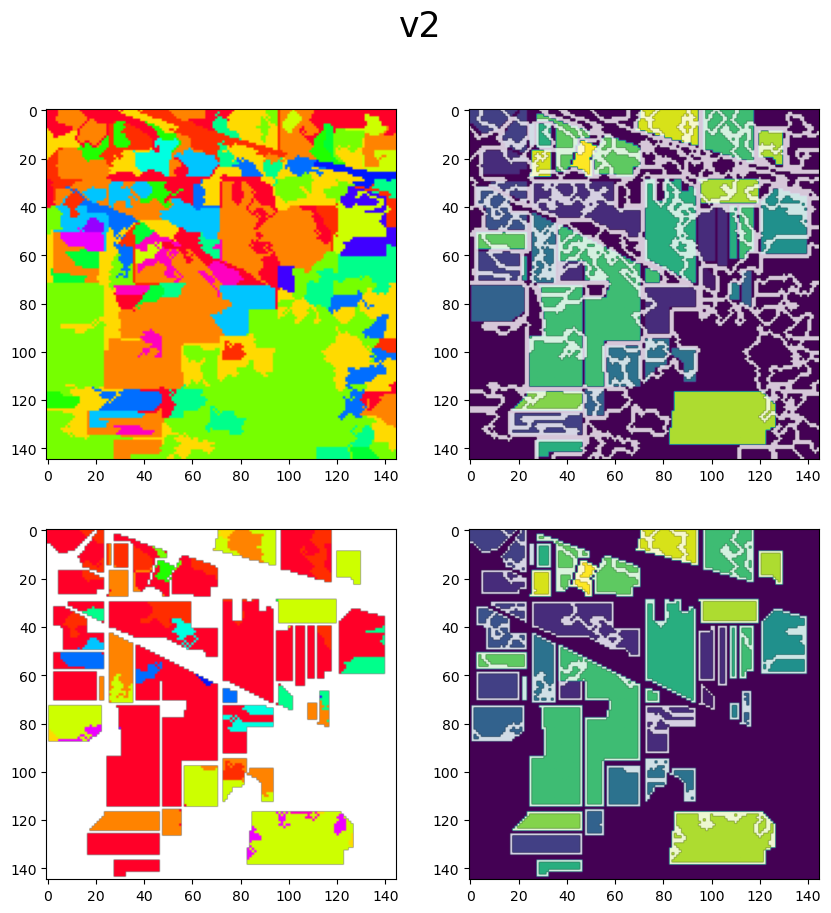

17
[5568, 395, 172, 1289, 412, 5294, 1402, 707, 805, 3760, 159, 102, 407, 40, 258, 61, 194]
17
[3836, 375, 182, 1228, 383, 932, 162, 406, 1361, 46, 82, 187, 287, 304, 244, 32, 202]


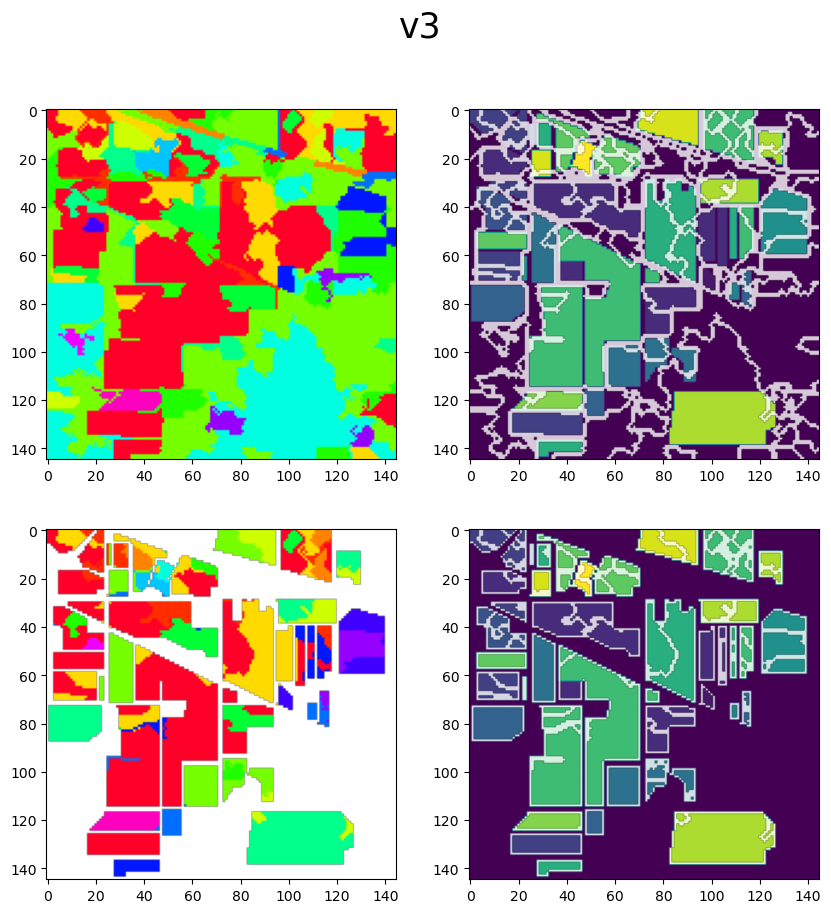

17
[407, 1652, 1338, 1870, 846, 904, 1185, 648, 835, 1842, 954, 952, 2063, 1747, 2407, 497, 878]
17
[269, 383, 895, 685, 397, 1574, 304, 793, 438, 162, 306, 342, 46, 676, 818, 1806, 355]


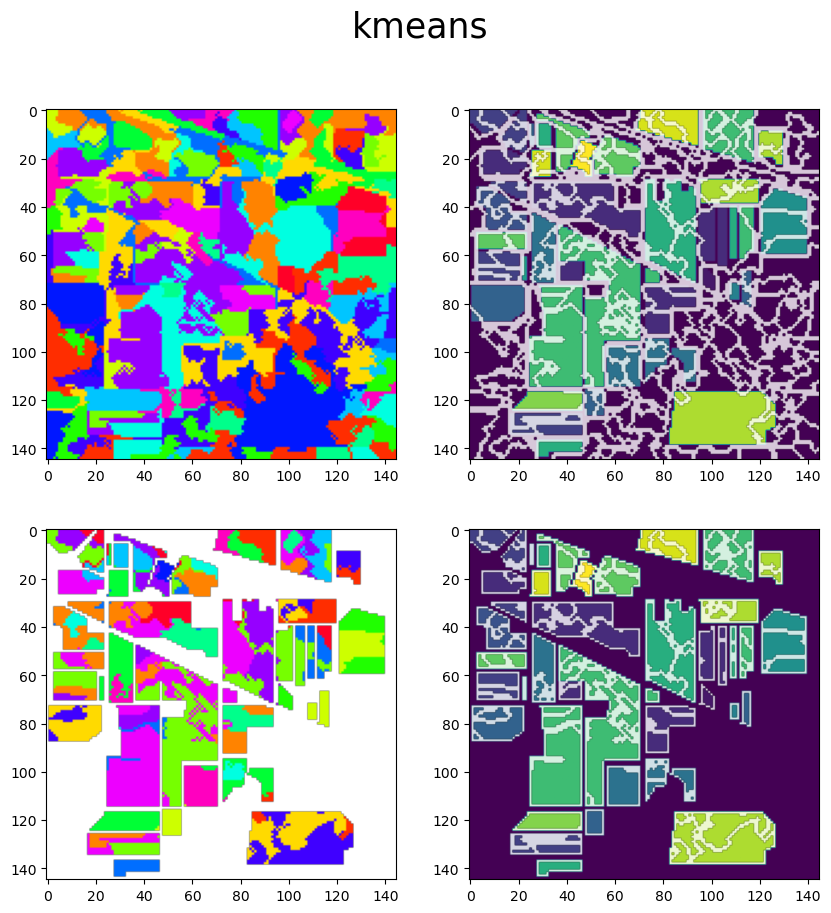

17
[3449, 1118, 2866, 1699, 1362, 1063, 708, 497, 1288, 992, 407, 1184, 412, 356, 159, 2190, 1275]
17
[1345, 399, 990, 376, 607, 128, 783, 355, 1268, 968, 304, 383, 202, 113, 163, 1472, 393]


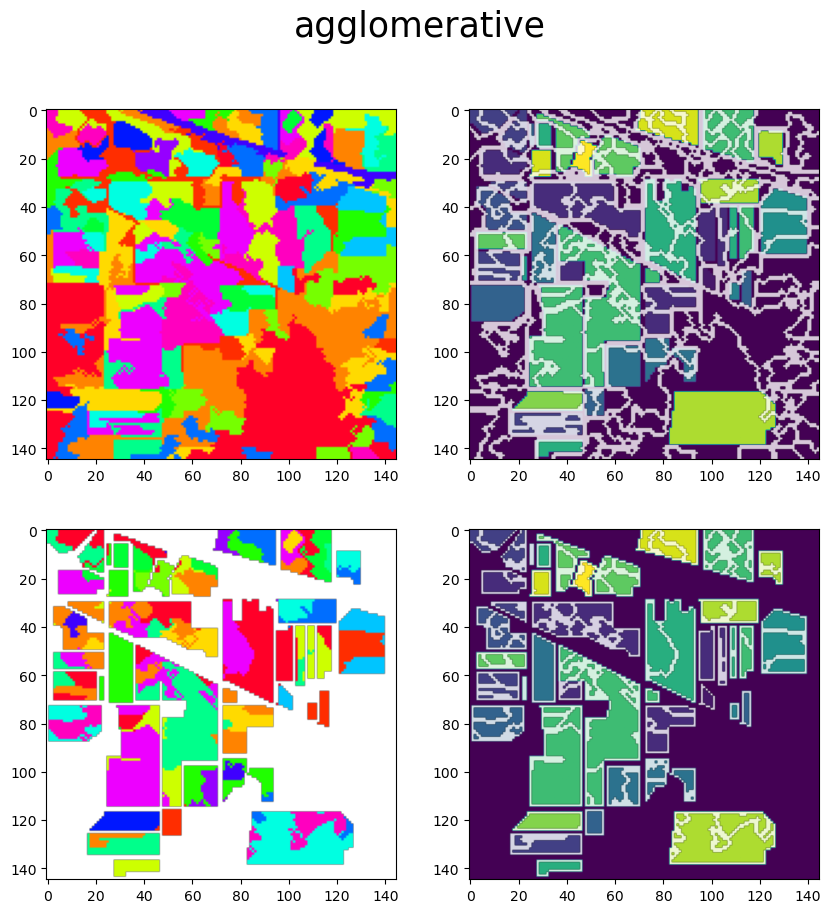

17
[838, 930, 1563, 1434, 1346, 1054, 1283, 1005, 967, 805, 1754, 591, 893, 1207, 1159, 2652, 1544]
17
[538, 723, 442, 860, 801, 430, 805, 556, 460, 383, 959, 333, 361, 490, 1190, 591, 327]


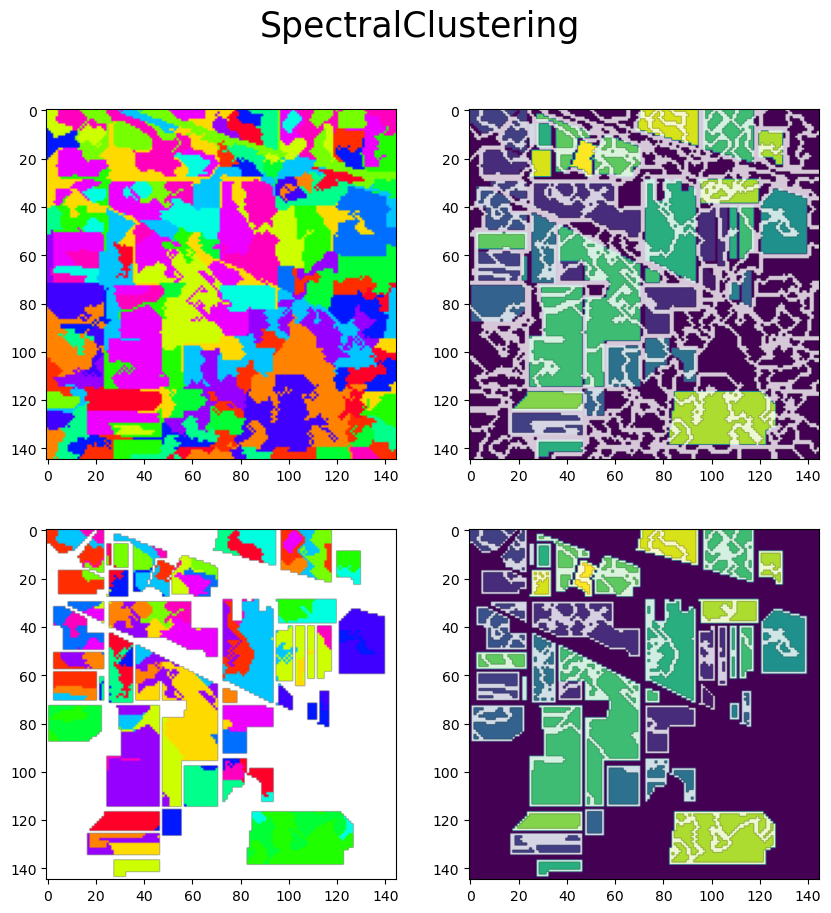

In [ ]:
length = len(merged_SPs_names)
for i in range(length):

    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    cmap = mpl.colormaps["gist_rainbow"]
    #np.random.shuffle(colors)
    n,m,_ = dataForMerges.shape

    for k,key in enumerate(mergedSPsDic.keys()):
        SPs = mergedSPsDic[key][i]
        colors = cmap(np.linspace(0, 1, len(SPs)))
        print(len(SPs))
        print([len(SP) for SP in SPs])
        img = np.zeros((n,m,len(colors[0])))
        for j,SP in enumerate(SPs):
            for x,y in SP:
                img[x,y] = colors[j]

        axs[k][0].imshow(img)

        axs[k][1].imshow(usedDataset["gt"])
        mask = ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200])
        if merged_SPs_names[i]=="without":
            for SP in SPs:
                x,y = np.average(SP, axis=0)
                mask[int(x), int(y)] = [255,0,0,255]
        axs[k][1].imshow(mask)

    fig.suptitle(merged_SPs_names[i], fontsize=25)
    plt.show()

### SVM

In [10]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}


### SSGA

In [29]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1
    b = 60

best_bands = []
best_fitness = []
best_accuracy = []

A = 200
chooseRandom = False
trainingData = usedDataset["data"]
Ssp_list = SSGA.compute_Sbsp_Stsp_list(trainData, SPs)
for i in range(A):
    if chooseRandom:
        bands = np.zeros(B, dtype=int)
        bands[:Param.b] = 1
        np.random.shuffle(bands)
        bands_fitness = SSGA.fitness_function(bands, Ssp_list[0], Ssp_list[1])
    else:
        pop, fitness = SSGA.SSGA(trainingData, Param.b, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPs, S_list=Ssp_list)
        bands = pop[0]
        bands_fitness = fitness[0]
        
    best_fitness.append(bands_fitness)
    best_bands.append(bands)
    X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
    best_accuracy.append(SVM_accuracy(X_train,y_train, X_test,y_test))


indices = [i for i in range(A)]
indices.sort(key=lambda i:best_fitness[i])
best_bands = [best_bands[i] for i in indices]
best_fitness = [best_fitness[i] for i in indices]
best_accuracy = [best_accuracy[i] for i in indices]

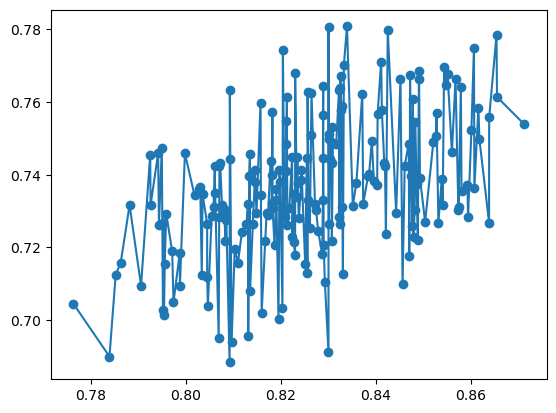

In [28]:
# Random
plt.plot(best_fitness, best_accuracy, "-o")
plt.show()

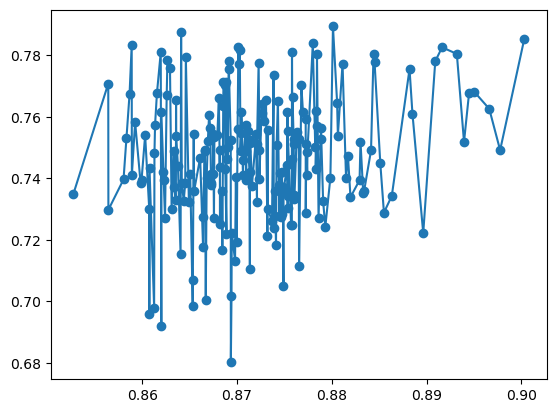

In [30]:
plt.plot(best_fitness, best_accuracy, "-o")
plt.show()

##### 9 bands

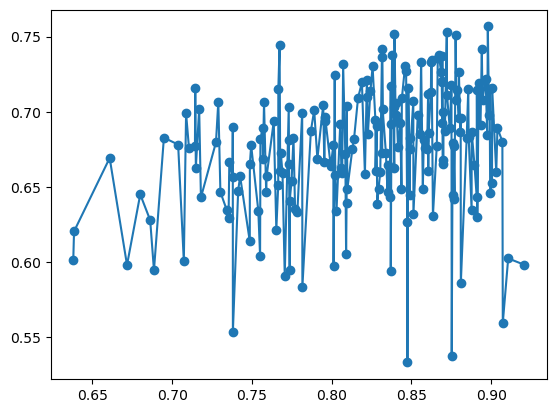

In [ ]:
# Random
plt.plot(best_fitness, best_accuracy, "-o")
plt.show()

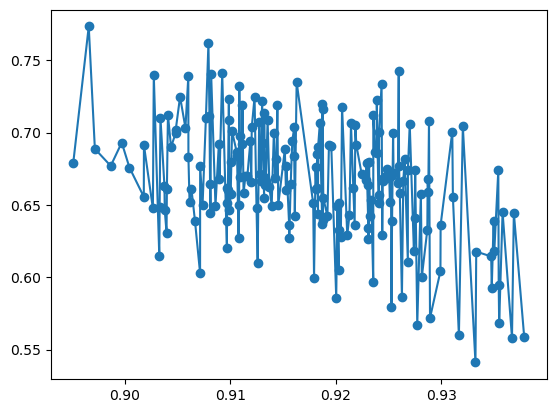

In [104]:
plt.plot(best_fitness, best_accuracy, "-o")
plt.show()

In [31]:
best = 0 
for i in range(A):
    if best_accuracy[i]>best_accuracy[best]:
        best=i
print(best)
print([i for i in range(B) if best_bands[best][i]==1])
print(best_fitness[best])
print(best_accuracy[best])

171
[7, 11, 14, 15, 17, 20, 21, 22, 24, 27, 33, 34, 35, 37, 46, 48, 58, 63, 65, 66, 70, 74, 77, 83, 98, 100, 104, 109, 111, 112, 119, 123, 125, 127, 129, 130, 131, 133, 134, 137, 138, 139, 146, 152, 156, 157, 159, 162, 164, 168, 171, 172, 173, 174, 175, 176, 177, 179, 184, 194]
0.880119143762179
0.7894088669950738


Good bands:
- Indian Pines:
    - 9: [10, 23, 40, 97, 124, 137, 147, 183, 185]
    - 60: [7, 11, 14, 15, 17, 20, 21, 22, 24, 27, 33, 34, 35, 37, 46, 48, 58, 63, 65, 66, 70, 74, 77, 83, 98, 100, 104, 109, 111, 112, 119, 123, 125, 127, 129, 130, 131, 133, 134, 137, 138, 139, 146, 152, 156, 157, 159, 162, 164, 168, 171, 172, 173, 174, 175, 176, 177, 179, 184, 194]


In [ ]:
bands = np.zeros(B, dtype=int)
bands[:Param.b] = 1
np.random.shuffle(bands)



X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
print(SSGA.fitness_function(bands, Ssp_list[0], Ssp_list[1]))
print(SVM_accuracy(X_train,y_train, X_test,y_test))

0.8783873386713854
0.7214696223316913


In [48]:
print([i for i in range(len(bands)) if bands[i]==1])

[10, 15, 26, 27, 57, 128, 150, 186, 191]


good indiv:
- IndianPines:
    - [9, 27, 35, 39, 70, 122, 148, 172, 183]
    - [10, 23, 40, 97, 124, 137, 147, 183, 185]